# Main notebook for the simulator

## Notes
- Right now focusing on linear road, using only an excerpt of tuples, and considering only position reports (tuples with type=0). The file has been created with
  - `head -n 100000 input.txt | grep -e "^0," > ../../../aggregate_modeling/data/input_stream_lr.csv`

Python related commands:
 - `conda create --name aggregate_modeling python=3.12 -y`
 - `conda activate aggregate_modeling`
 - `install ipykernel`

## Input parameters

In [46]:
input_file = '../data/input_stream_lr.csv' 
mst_input_stream_file = '../data/MST_input_stream_lr.csv'
mst_output_stream_file = '../data/MST_output_stream_lr.csv'
mee_events_file = '../data/MEE_events_lr.csv'
input_event_mapping =  '../data/input_event_lr.csv'
event_output_mapping =  '../data/event_output_lr.csv'
WA = 200 * 1000
WS = 600 * 1000

throughput_fig = '../data/throughput.png'
outputrate_fig = '../data/outputrate.png'
latency_fig = '../data/latency.png'

# Set to true if you also want to write input/event and event/output mappings. Mostly for debugging
write_mappings = True

extract_time = lambda line: int(line.split(",")[1])*1000  # Extracts second value as integer time, that's the format for LR tuples, multiplies by 1000 to get ms
extract_key = lambda line: line.split(",")[2].strip()  # Extracts third value as key, the vehicle id

In [35]:
import random

CREATE_duration = lambda: random.uniform(0.001, 0.1)
UPDATE_duration = lambda: random.uniform(0.001, 0.1)
OUTPUT_duration = lambda: random.uniform(0.001, 0.1)
DELETE_duration = lambda: random.uniform(0.001, 0.1)

# The following are the main classes / utily functions / simulator code. Should not be modified

In [ ]:
# Imports
import csv
from enum import Enum
import sys
from tqdm import tqdm  # Import tqdm for progress bar
import bisect
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

In [ ]:
# Model Stream Tuple
class MST:
    def __init__(self, id, omega, tau, w, k):
        self.id = id # The unique ID
        self.omega = omega # The wallclock time
        self.tau = tau # The event time
        self.w = w # Boolean specifying whether this is a watermark or a regular tuple
        self.k = k # The associated key

    def to_list(self):
        """Convert the object to a list for CSV writing."""
        return [self.id, self.omega, self.tau, self.w, self.k]

# Window Action
class WinAction (Enum):  
    CREATE = 1
    UPDATE = 2
    OUTPUT = 3
    DELETE = 4

# Model Execution Event
class MEE:
    def __init__(self, id, omega, tau, winAction, k):
        self.id = id # The unique ID
        self.omega = omega # The wallclock time
        self.tau = tau # The event time
        self.winAction = winAction # Action 
        self.k = k # The associated key

    def to_list(self):
        """Convert the object to a list for CSV writing."""
        return [self.id, self.omega, self.tau, self.winAction, self.k]
    
def get_sliding_window_starts(tau, WA, WS):
    """
    Returns a list of all starting times of sliding windows that contain tau.
    
    :param tau: The event time
    :param WA: The window advance (step size)
    :param WS: The window size
    :return: A list of start times of windows containing tau
    """
    start_times = []
    latest_start = math.floor(tau/WA)*WA  # Latest possible window start containing tau
    start_times.append(latest_start)

    while tau < latest_start-WA+WS:
        latest_start = latest_start - WA
        start_times.append(latest_start)
        
    return sorted(start_times)

def aggregate_and_plot(
    input_csv,
    time_column,
    agg_function,
    value_column=None,
    output_plot_file="output_plot.png"
):
    # Check if the file exists
    if not os.path.isfile(input_csv):
        raise FileNotFoundError(f"The file '{input_csv}' does not exist.")
    
    # Read the CSV file
    df = pd.read_csv(input_csv)
    
    # Validate that necessary columns exist
    if time_column not in df.columns:
        raise ValueError(f"Time column '{time_column}' not found in CSV file.")
    if agg_function in ["sum", "average"] and (value_column is None or value_column not in df.columns):
        raise ValueError(f"Value column '{value_column}' is required for aggregation function '{agg_function}'.")
    
    # Convert time column to seconds
    df[time_column] = df[time_column] // 1000  # Convert from ms to seconds
    
    # Perform aggregation
    if agg_function == "count":
        aggregated_df = df.groupby(time_column).size().reset_index(name="count")
    elif agg_function == "sum":
        aggregated_df = df.groupby(time_column)[value_column].sum().reset_index()
    elif agg_function == "average":
        aggregated_df = df.groupby(time_column)[value_column].mean().reset_index()
    else:
        raise ValueError("Invalid aggregation function. Use 'count', 'sum', or 'average'.")
    
    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(aggregated_df[time_column], aggregated_df.iloc[:, 1], marker='o', linestyle='-')
    plt.xlabel("Time (seconds)")
    plt.ylabel(agg_function.capitalize())
    plt.title(f"Aggregation ({agg_function}) over time")
    plt.grid()
    plt.show()
    
    # Save plot to file
    plt.savefig(output_plot_file)
    plt.close()
    print(f"Plot saved to {output_plot_file}")

In [38]:
def process_stream(input_file, mst_input_stream, extract_time, extract_key):
    counter = 0
    last_tau = None
    non_decreasing = True

    with open(input_file, 'r') as infile, open(mst_input_stream, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(["id", "omega", "tau", "w", "k"])  # CSV header

        for line in infile:
            tau = extract_time(line)  # Extract event time
            k = extract_key(line)  # Extract key

            # Check if tau decreased
            if last_tau is not None and tau < last_tau:
                non_decreasing = False

            # If tau increased, insert a watermark tuple before the new tau
            if last_tau is not None and tau > last_tau:
                watermark = MST(counter, last_tau, last_tau, True, None)
                writer.writerow(watermark.to_list())
                counter += 1

            # Create regular tuple
            mst = MST(counter, tau, tau, False, k)
            writer.writerow(mst.to_list())
            counter += 1

            last_tau = tau

        # At the end, a final watermark that flushes everything
        watermark = MST(counter, last_tau, sys.maxsize, True, None)
        writer.writerow(watermark.to_list())
        
    return non_decreasing

In [32]:
non_decreasing = process_stream(input_file, mst_input_stream_file, extract_time, extract_key)

if non_decreasing:
    print('Tuples had non-decreasing event times, so mst_input_stream_lr.csv can be used as is')
else:
    print('Tuples had decreasing event times, so mst_input_stream_lr.csv should be adjusted to have consistent watermarks')


Tuples had non-decreasing event times, so mst_input_stream_lr.csv can be used as is


In [33]:
def process_mst_stream(
    mst_input_stream_file,  # Input CSV for MST input tuples
    mee_events_file,  # Output CSV for MEE events
    input_event_mapping,  # Output CSV for input-event mappings
    mst_output_stream_file, # Input CSV for MST output tuples
    event_output_mapping, # Output CSV for event-output mappings
    WA,  # Window advance (step size)
    WS  # Window size
):
    
    wins = set() # Set keeping track of the open windows
    pendingMEEs = [] # Buffer of temporary events that are waiting for a watermark to be triggered
    event_counter = 0 # counter used as id of the MEE events
    output_counter = 0 # counter used as id of MST output tuples
    accumulated_execution_time = 0.0 # used to keep track of actual execution time of each window action/output tuple
    
    with open(mst_input_stream_file, 'r') as infile, \
            open(mee_events_file, 'w', newline='') as out_mee, \
            open(input_event_mapping, 'w', newline='') as out_event_map, \
            open(mst_output_stream_file, 'w', newline='') as output, \
            open(event_output_mapping, 'w', newline='') as event_output:
        
        mst_reader = csv.reader(infile)
        next(mst_reader)  # Skip header

        # This part is to show a progress bar
        total_rows = sum(1 for _ in infile)  # Count total rows
        infile.seek(0)  # Reset file pointer
        next(mst_reader)  # Skip header again
        
        mee_writer = csv.writer(out_mee)
        event_map_writer = csv.writer(out_event_map)
        output_writer = csv.writer(output)
        event_output_writer = csv.writer(event_output)
        
        mee_writer.writerow(["i", "omega", "tau", "winAction", "k"])
        event_map_writer.writerow(["input_id", "event_id"])
        output_writer.writerow(["i", "omega", "tau", "w", "k", "l"])
        event_output_writer.writerow(["event_id", "output_id"])
        
        for row in tqdm(mst_reader, total=total_rows, desc="Processing Rows", unit="row"):
            i, omega, tau, w, k = int(row[0]), int(row[1]), int(row[2]), row[3] == 'True', row[4] if row[4] != 'None' else None
        
            if not w:  # Regular tuple

                # Adjust the accumulated time
                accumulated_execution_time = max(omega, accumulated_execution_time)

                for start_time in get_sliding_window_starts(tau, WA, WS):
                    if (start_time, k) not in wins:
                        # A window is being created
                        wins.add((start_time, k))
                        # output the event
                        mee_writer.writerow([event_counter, int(accumulated_execution_time), start_time, WinAction.CREATE.name, k])
                        if write_mappings:
                            event_map_writer.writerow([i, event_counter])
                        # Keep track of time passing
                        accumulated_execution_time += CREATE_duration()
                        # Remember there's an output (and a delete action to take care of later on)
                        bisect.insort(pendingMEEs, [None, None, start_time + WS - 1, WinAction.OUTPUT.name, k], key=lambda x: x[2])
                        event_counter += 1
                    
                    mee_writer.writerow([event_counter, int(accumulated_execution_time), start_time, WinAction.UPDATE.name, k])
                    if write_mappings:
                        event_map_writer.writerow([i, event_counter])
                    event_counter += 1
            else:  # Watermark
                while pendingMEEs and pendingMEEs[0][2] <= tau:
                    
                    # pop the output event and adjust times
                    x = pendingMEEs.pop(0)
                    x[0] = event_counter
                    x[1] = int(accumulated_execution_time)
                    output_event_time = x[2]
                    k = x[4]
                    
                    # Write the output event
                    mee_writer.writerow(x)
                    if write_mappings:
                        event_map_writer.writerow([i, event_counter])
                    
                    # Adjust accumulated time
                    accumulated_execution_time += OUTPUT_duration()

                    # Write output
                    output_writer.writerow([output_counter, int(accumulated_execution_time), output_event_time, False, k, int(accumulated_execution_time)-omega])
                    if write_mappings:
                        event_output_writer.writerow([event_counter, output_counter])
                    
                    # Now write the deletion event
                    mee_writer.writerow([event_counter+1, int(accumulated_execution_time), None, WinAction.DELETE.name, x[4]])
                    if write_mappings:
                        event_map_writer.writerow([i, event_counter+1])
                    
                    event_counter += 2
                    output_counter += 1

                    accumulated_execution_time += DELETE_duration()
                    

process_mst_stream(mst_input_stream_file, mee_events_file, input_event_mapping, mst_output_stream_file, event_output_mapping, WA, WS)

Processing Rows: 100%|██████████| 100513/100513 [38:43<00:00, 43.27row/s]


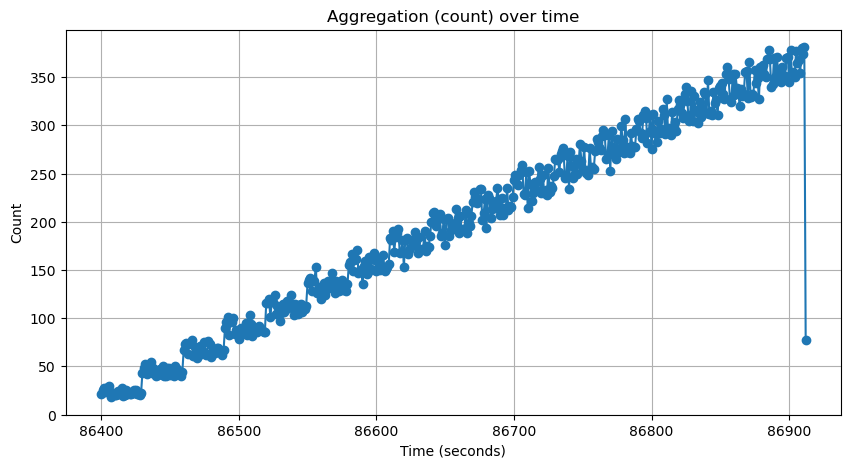

Plot saved to ../data/throughput.png


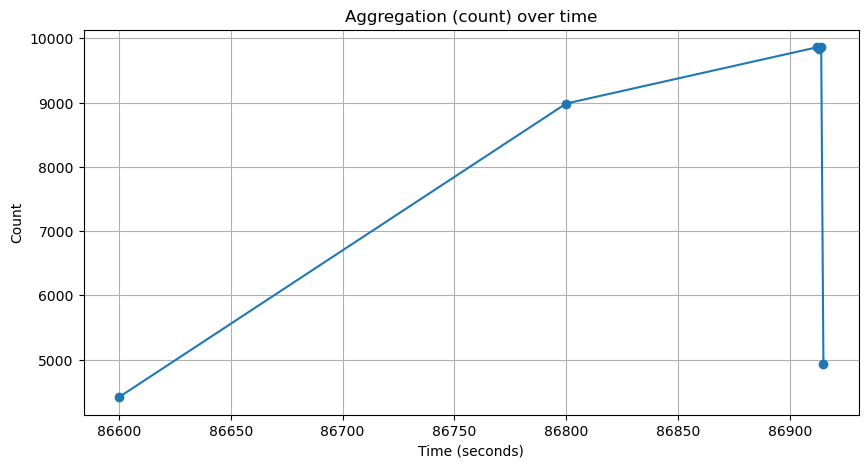

Plot saved to ../data/outputrate.png


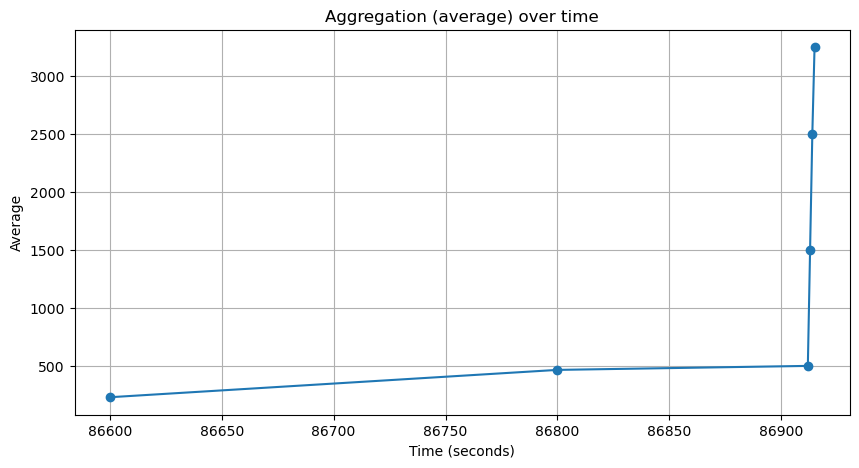

Plot saved to ../data/latency.png


In [47]:
aggregate_and_plot(mst_input_stream_file, "omega", "count", None, throughput_fig)
aggregate_and_plot(mst_output_stream_file, "omega", "count", None, outputrate_fig)
aggregate_and_plot(mst_output_stream_file, "omega", "average", "l", latency_fig)

# Comments on the experiments 

## 25/03/10
- Seems correct, but also extremely slow. Around 45 rows/second (or tuples/second)
- Of course one of the fundamental things is to show that the simulator is significantly faster then the actual aggregate
- Made the writing of input/event and event/output mapping optional (no visible speed change, though)
- Right now the output stream of MST does not contain watermarks, consider adding that?
- the statistics need to be fixed, for instance with None when values are not defined
- Also, for the statistics
  - CPU consumption is a different thing, needs more data preparation
  - Memory too, we need estimators of how much each tuple adds to the window
- For the Aggregate, we could have an Aggregate with sampling features that can be used to profile a bit the expected execution